#### Xây dựng chương trình sử dụng mô hình **Multinomial Logistic Regression (Softmax)** để phân loại các hình ảnh chữ số viết tay

In [77]:
# print current working directory
import os
print(os.getcwd())

/media/ngan/Dulieu/machine-learning/labs/project


In [78]:
# set names to the paths because they're too long
data_path = '/media/ngan/Dulieu/machine-learning/labs/project'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# valid path
valid_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
valid_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [79]:
import numpy as np

In [80]:
# build a method for reading data from a gzip file, decompressing it, 
# and converting it into a format of a sequence of images (a sequence of integer matrices)
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    # read data
    import gzip # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 valid)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
        # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [81]:
#Call the data reading method to check if it reads correctly.
x, y = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
# valid_images, valid_labels = get_mnist_data(valid_images_path, valid_labels_path, 10000, _is=False, shuffle=True)
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(x, y, test_size=0.3, random_state=42)
print(train_images.shape, train_labels.shape)
print(valid_images.shape, valid_labels.shape)

(3500, 784) (3500,)
(1500, 784) (1500,)


In [82]:
# program segment contains user-defined methods for multilayer logistic regression
# Convert matrix to image
def get_image(image):
    return image.reshape(28, 28)
# These methods are from Vi du 1
def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y),(y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A
def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A
def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [83]:
# program segment contains a procedure for computing using
# the Stochastic Gradient Descent method in multiclass logistic regression model.
def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=20, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss
    losses = []
    _theta = theta
    d, N = X.shape
    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")       
    return _theta, losses

2 2


<Figure size 640x480 with 0 Axes>

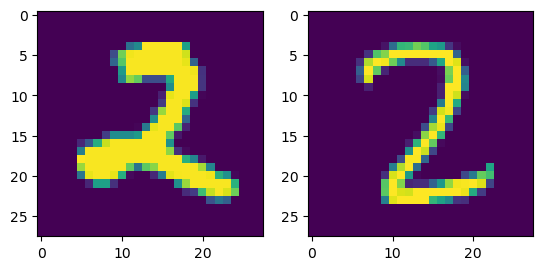

In [84]:
# for display and valid digit 
import random
import matplotlib.pyplot as plt
index = random.randint(0, 500)
print(train_labels[index], valid_labels[index])
train_image = np.asarray(get_image(train_images[index])).squeeze()
valid_image = np.asarray(get_image(valid_images[index])).squeeze()
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(valid_image)
plt.show()

(785, 3500)
(10, 3500)


<Figure size 640x480 with 0 Axes>

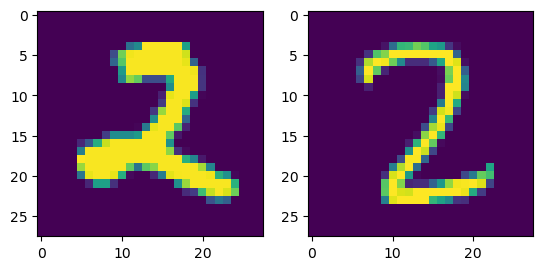

In [85]:
# prepare train data
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T),axis = 0)
Y_train = convert_labels(train_labels, 10)
print(X_train.shape)
print(Y_train.shape)
train_image = np.asarray(get_image(train_images[index])).squeeze()
valid_image = np.asarray(get_image(valid_images[index])).squeeze()
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(valid_image)
plt.show()

In [86]:
theta = np.zeros((X_train.shape[0], 10))
opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

epoch 0 - cost 0.7572778903161814
epoch 1 - cost 0.7477879247041738
epoch 2 - cost 0.7453762934827983
epoch 3 - cost 0.7377067861959554
epoch 4 - cost 0.7437193837110299
epoch 5 - cost 0.7431356996977938
epoch 6 - cost 0.7388011686574083
epoch 7 - cost 0.7397780071593196
epoch 8 - cost 0.7397594177954159
epoch 9 - cost 0.7353606158007173
epoch 10 - cost 0.7389670195345772
epoch 11 - cost 0.7370534615648872
epoch 12 - cost 0.7364600808486823
epoch 13 - cost 0.7380500831164991
epoch 14 - cost 0.7393117471947966
epoch 15 - cost 0.739291681109741
epoch 16 - cost 0.7382591036201568
epoch 17 - cost 0.7379208841190928
epoch 18 - cost 0.7382180531864222
epoch 19 - cost 0.7366314168168606
training success:  (785, 10) 350


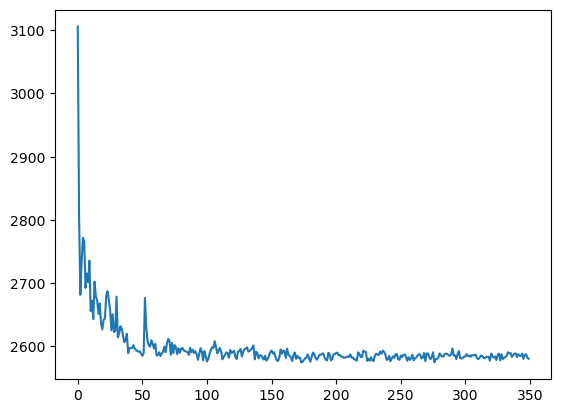

In [87]:
plt.plot(losses)

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('accuracy training data: ', accuracy_score(train_labels,pred(opt_theta, X_train))*100)
X_valid = np.concatenate((np.ones((1, valid_images.shape[0])), valid_images.T),axis = 0)
print(X_valid.shape)
print('accuracy validing data: ', accuracy_score(valid_labels,pred(opt_theta, X_valid))*100)
print('precision validing data: ', precision_score(valid_labels,pred(opt_theta, X_valid), average='macro')*100)
print('recall validing data: ', recall_score(valid_labels,pred(opt_theta, X_valid), average='macro')*100)
print('f1_score validing data: ', f1_score(valid_labels,pred(opt_theta, X_valid), average='macro')*100)

accuracy training data:  95.85714285714285
(785, 1500)
accuracy validing data:  86.66666666666667
precision validing data:  87.07431839477032
recall validing data:  86.42512168785392
f1_score validing data:  86.43849309777092


In [89]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(valid_labels,pred(opt_theta, X_valid))
# print(cm)

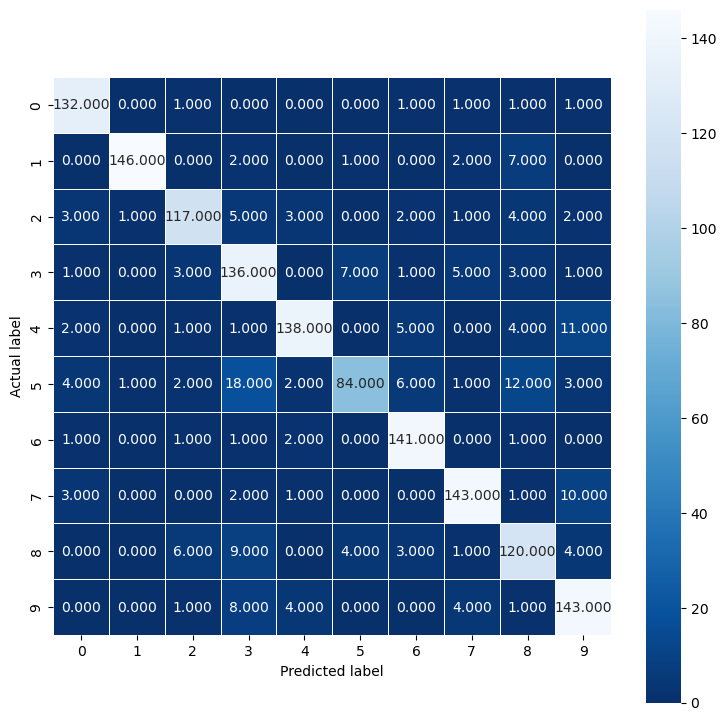

In [90]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

**Đưa tập dữ liệu đã đọc về còn 2 chiều và hiển thị lên màn hình để xem quan hệ giữa các lớp dữ liệu.**

In [91]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt

In [92]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
X2d = pca.fit_transform(x)

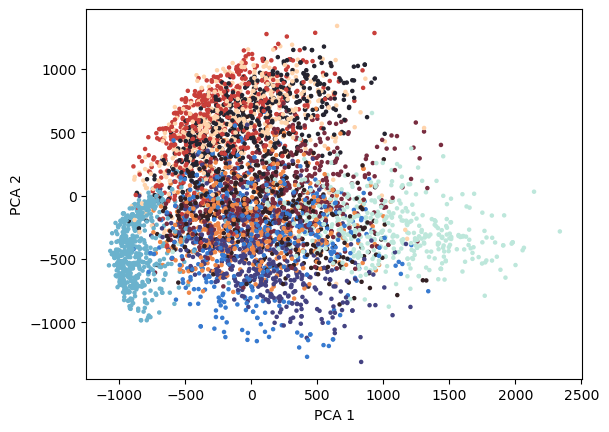

In [93]:
# plt.figure(figsize=(5, 4))  # Set the figure size (width=8 inches, height=6 inches)
plt.scatter(X2d[:, 0], X2d[:, 1], c=y,s=5, cmap='icefire')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [94]:
transformed=pd.DataFrame(pca.fit_transform(train_images))
train_pca = pca.inverse_transform(transformed)

Text(0.5, 0, '2 components')

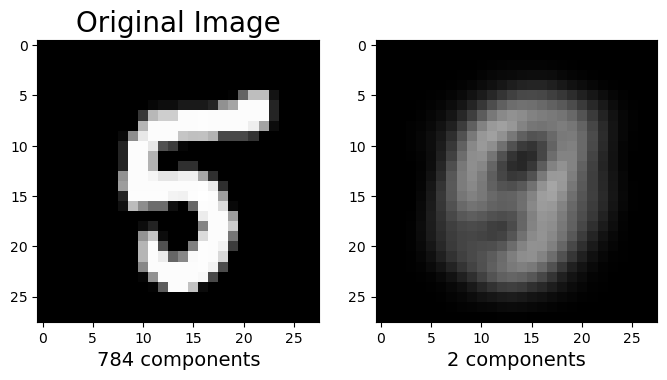

In [95]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_images[11].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 2 principal components
plt.subplot(1, 2, 2);
plt.imshow(train_pca[11].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('2 components', fontsize = 14)

### Sử dụng các thư viện của gói linear_model, lớp LogisticRegression và so sánh kết quả.

In [96]:
from sklearn.linear_model import LogisticRegression

In [97]:
lorg=LogisticRegression(multi_class='multinomial',solver='sag')

# and train model by Training Dataset
lorg.fit(train_images, train_labels)
Y_pred2 = lorg.predict(valid_images)

/home/ngan/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [98]:
Y_pred1 = lorg.predict(train_images)
print('Tập train: accuracy ',accuracy_score(train_labels,Y_pred1))

Tập train: accuracy  1.0


In [99]:
from sklearn.metrics import accuracy_score
print("Tập valid: accuracy = ",accuracy_score(valid_labels,Y_pred2)*100)
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(valid_labels,Y_pred2,average='macro')*100
recall = recall_score(valid_labels,Y_pred2,average='macro')*100
f1 = f1_score(valid_labels,Y_pred2, average='macro')*100
print('precision=', precision)
print('recall=', recall)
print('f1_score=', f1)

Tập valid: accuracy =  88.93333333333334
precision= 88.81109929376771
recall= 88.82911237326584
f1_score= 88.74969921708666


In [100]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(valid_labels,Y_pred2)
# print(cm)

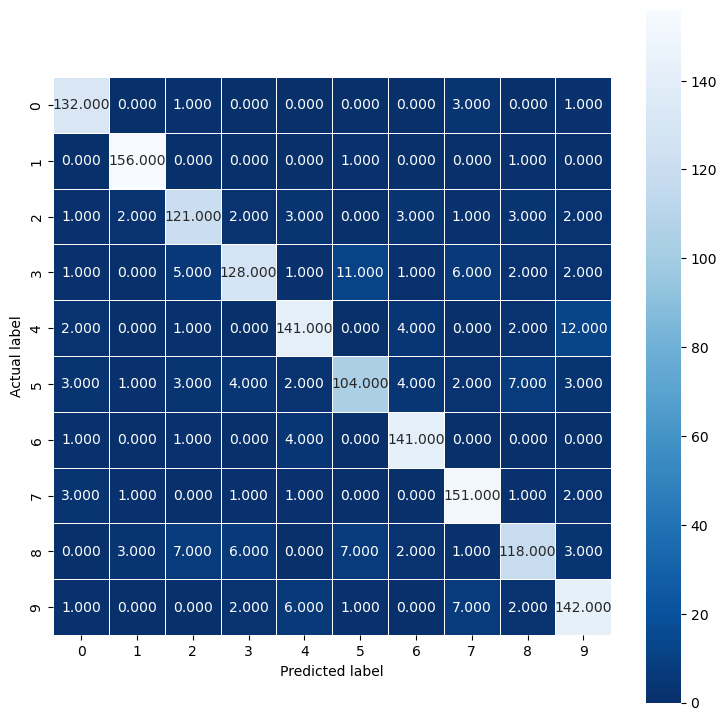

In [101]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
# plt.title('all_sample_title', size = 15);

    DBSCAN

In [102]:
from sklearn.preprocessing import MinMaxScaler


In [103]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
X2d = pca.fit_transform(X2d)


In [104]:
std = MinMaxScaler() # chuan hoa du lieu
X2d = std.fit_transform(X2d)

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

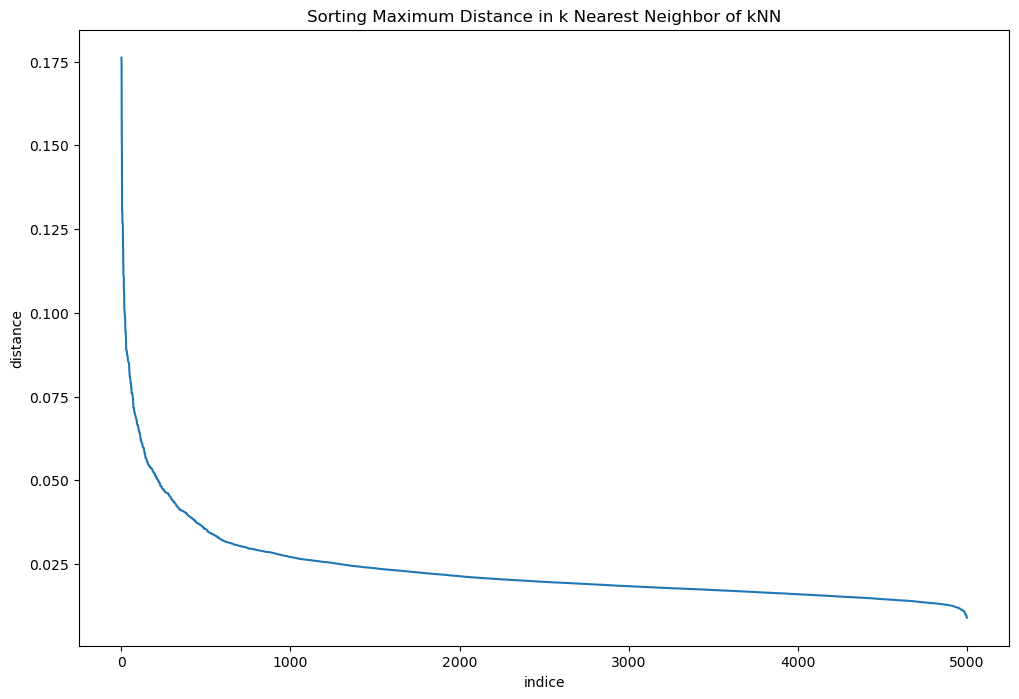

In [105]:
from sklearn.neighbors import NearestNeighbors
# Xây dựng mô hình k-Means với k=20
neighbors = 20
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(X2d)
# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X2d)
# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)
# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
# plt.axhline(y=0.02)
# plt.text(2, 0.02, 'y = 0.02', fontsize=12)
# plt.axhline(y=0.025)
# plt.text(2, 0.025, 'y = 0.025', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

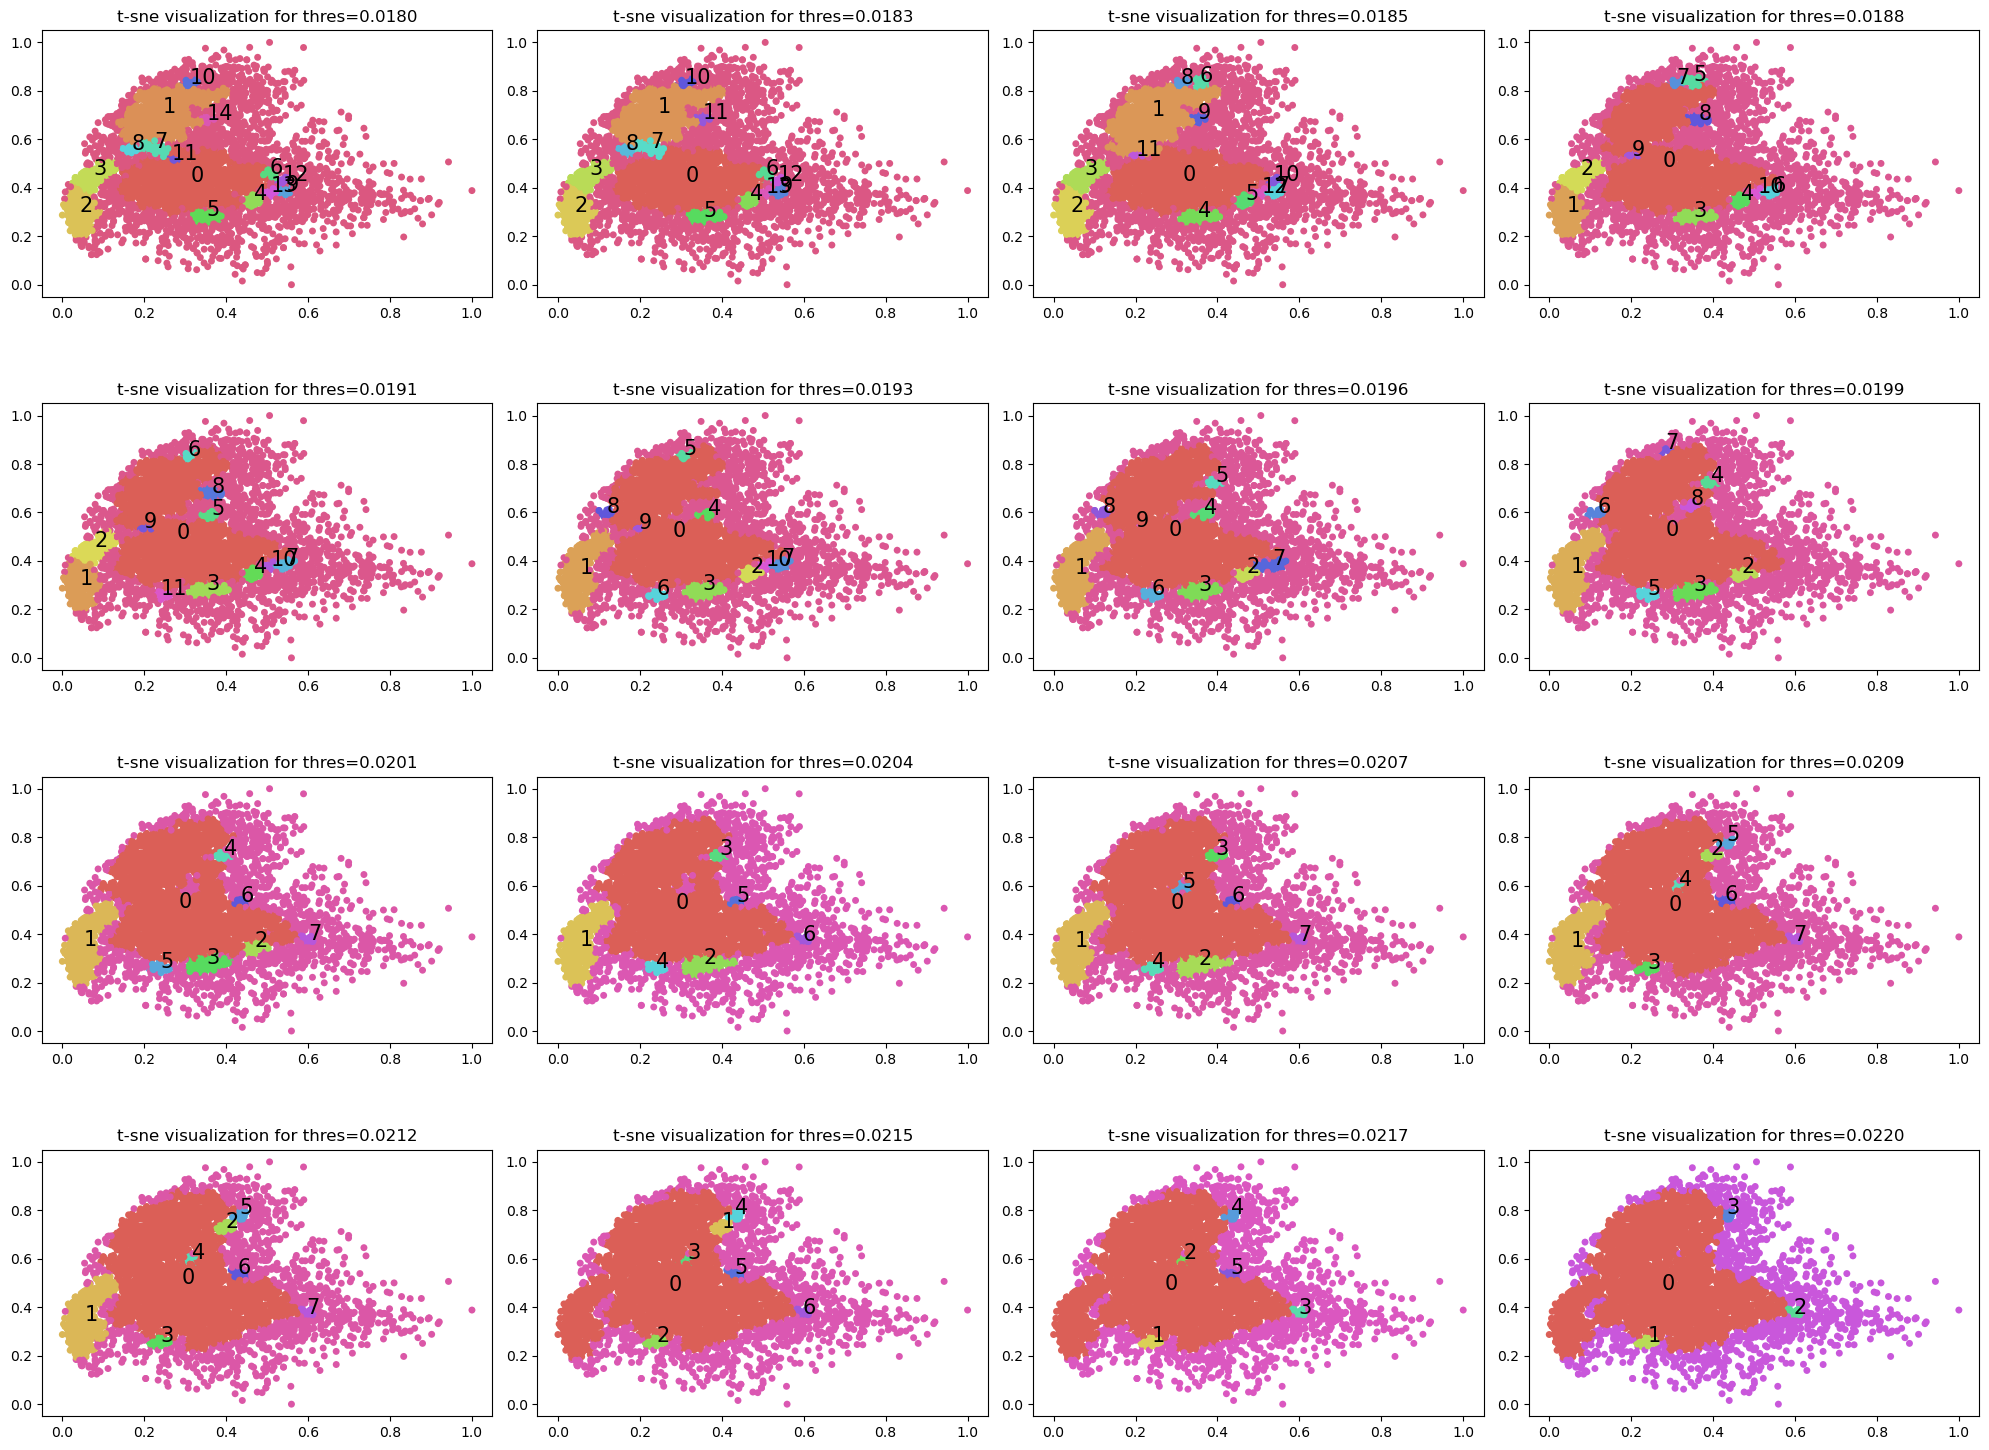

In [106]:
from matplotlib import patheffects
# import sklearn.manifold.TSNE
from matplotlib.gridspec import GridSpec
import warnings

from sklearn.cluster import DBSCAN
warnings.simplefilter("ignore", category=RuntimeWarning)

def _plot_kmean_scatter1(X, labels, gs, thres):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=25, c=palette[labels.astype(int)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=15)
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

gs = GridSpec(4,4)
plt.figure(figsize = (25, 18))
plt.subplots_adjust(wspace=0.1,hspace=0.4)

# for i, thres in enumerate(np.linspace(0.03, 0.04,16)):

for i, thres in enumerate(np.linspace(.018,0.022, 16)):
    dbscan = DBSCAN(eps=thres, min_samples=20, metric='euclidean')
    labels = dbscan.fit_predict(X2d)
    _plot_kmean_scatter1(X2d, labels, gs[i], thres)